# R4 on Salient ImageNet

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import random
sys.path.append(os.path.abspath('..'))
from models.R4_models import SalientImageNet
from models.pipeline import (train_model_with_pgd_robust_input_grad, write_results_to_file,
                             train_model_with_smoothed_input_grad)
from datasets import salient_imagenet
from metrics import get_rcs_for_run, get_avg_rcs

# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
DELTA_INPUT_ROBUSTNESS_PARAM = 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
batch_size = 33
test_batch_size = 250

cuda:1


In [3]:
spurious_train_dset, spurious_test_dset, core_train_dset, core_test_dset = salient_imagenet.make_imagenet_subset_for_paper()

Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389
Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389


224 torch.Size([224, 224, 3]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(3)
224 torch.Size([224, 224, 3]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(1)


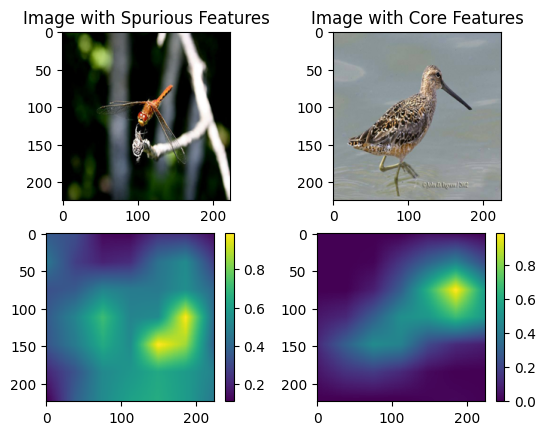

224 torch.Size([224, 224, 3]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0)
224 torch.Size([224, 224, 3]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0)


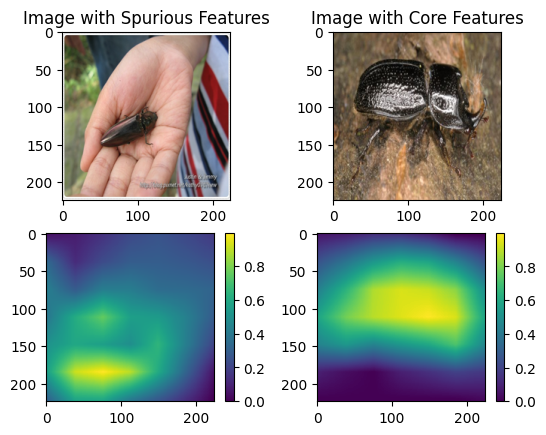

In [4]:
img_spur, img_spur_label, img_spur_mask = None, None, None
img_core, img_core_label, img_core_mask = None, None, None
rand_2 = torch.randint(0, len(spurious_train_dset), (2,))
for i in rand_2:
    img_spur, img_spur_label, img_spur_mask, _ = spurious_train_dset[i]
    img_core, img_core_label, img_core_mask, _ = core_train_dset[i]
    print(img_spur_mask.shape[0], img_spur.shape, torch.max(img_spur), torch.min(img_spur), img_spur_label)
    print(img_core_mask.shape[0], img_core.shape, torch.max(img_core), torch.min(img_core), img_core_label)
    fig, ax = plt.subplots(2, 2)
    ax[0][0].imshow(img_spur.numpy())
    ax[0][0].set_title("Image with Spurious Features")
    ax[0][1].imshow(img_core.numpy())
    ax[0][1].set_title("Image with Core Features")
    im_mask = ax[1][0].imshow(img_spur_mask[:, :, 0].numpy())
    fig.colorbar(im_mask, ax=ax[1][0])
    im_core_mask = ax[1][1].imshow(img_core_mask[:, :, 0].numpy())
    fig.colorbar(im_core_mask, ax=ax[1][1])
    plt.show()

In [5]:
dl_train = salient_imagenet.get_dataloader_train(spurious_train_dset, batch_size)
dl_test_spurious = salient_imagenet.get_dataloader_test(spurious_test_dset, test_batch_size)
dl_test_core = salient_imagenet.get_dataloader_test(core_test_dset, test_batch_size)
criterion = torch.nn.CrossEntropyLoss()
print(dl_train.dataset[:][1].unique(return_counts=True))
print(dl_test_spurious.dataset[:][1].unique(return_counts=True))
print(dl_test_core.dataset[:][1].unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5]), tensor([46, 83, 52, 47, 51, 54]))
(tensor([0, 1, 2, 3, 4, 5]), tensor([19, 37, 13, 18, 14, 11]))
(tensor([0, 1, 2, 3, 4, 5]), tensor([39, 47, 69, 49, 38, 30]))


## Experiments 

In [6]:
model_root_save_dir = "saved_experiment_models/performance/imagenet"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["pgd_r4", "std", "rand_r4", "smooth_r3", "r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)


### ERM

In [ ]:
std_method = "std"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 20, 1e-4, 1, -1, -1, -1
test_epsilon = 0.1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(1)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device)
    print(f"========== Testing model with method {std_method} restart {i} ==========")
    _, _ = get_rcs_for_run(dl_test_spurious, dl_test_core, curr_model, device)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
rcs, avg_spur_acc = get_avg_rcs(dl_test_spurious, dl_test_core, save_dir_for_method[std_method], device, suppress_logs=True)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"spur_acc": round(avg_spur_acc, 5),
                       "rcs": round(rcs, 5)}, std_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": None,
                         "multi_class": True,
                         "has_conv": True,
                         "with_k_schedule": False}, std_method)

# PGD-R4 training

In [ ]:
pgd_r4_method = "pgd_r4"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_decay = 30, 5e-5, 1, 0.5, 0.1, 0
test_epsilon = 0.1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(22)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {pgd_r4_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon,
        pgd_r4_method, k, device, num_iterations=10)
    print(f"========== Testing model with method {pgd_r4_method} restart {i} ==========")
    _, _ = get_rcs_for_run(dl_test_spurious, dl_test_core, curr_model, device)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
rcs, avg_spur_acc = get_avg_rcs(dl_test_spurious, dl_test_core, save_dir_for_method[pgd_r4_method], device, suppress_logs=True)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"spur_acc": round(avg_spur_acc, 5),
                       "rcs": round(rcs, 5)}, pgd_r4_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_decay": weight_decay,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": None,
                         "multi_class": True,
                         "has_conv": True,
                         "seed": 22,
                         "with_k_schedule": False}, pgd_r4_method)

## R3 Training

In [ ]:
r3_method = "r3"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_decay = 32, 4e-5, 1, 0, 100, 1e-5
test_epsilon = 0.1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(1)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {r3_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r3_method, k, device, weight_decay=weight_decay)
    print(f"========== Testing model with method {r3_method} restart {i} ==========")
    _, _ = get_rcs_for_run(dl_test_spurious, dl_test_core, curr_model, device)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[r3_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
rcs, avg_spur_acc = get_avg_rcs(dl_test_spurious, dl_test_core, save_dir_for_method[r3_method], device, suppress_logs=True)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"spur_acc": round(avg_spur_acc, 5),
                       "rcs": round(rcs, 5)}, r3_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_decay": weight_decay,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weightms": None,
                         "multi_class": True,
                         "has_conv": True,
                         "seed": 1,
                         "with_k_schedule": False}, r3_method)

## Smooth-R3 Training

In [ ]:
smooth_r3_method = "smooth_r3"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_decay, num_samples = 20, 6e-5, 1, 0.75, 100, 1e-5, 5
test_epsilon = 0.1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(22)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {smooth_r3_method} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3_method, k, device,
                                         weight_decay=weight_decay, num_samples=num_samples)
    print(f"========== Testing model with method {smooth_r3_method} restart {i} ==========")
    _, _ = get_rcs_for_run(dl_test_spurious, dl_test_core, curr_model, device)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
rcs, avg_spur_acc = get_avg_rcs(dl_test_spurious, dl_test_core, save_dir_for_method[smooth_r3_method], device, suppress_logs=True)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"spur_acc": round(avg_spur_acc, 5),
                       "rcs": round(rcs, 5)}, smooth_r3_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_decay": weight_decay,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": None,
                         "multi_class": True,
                         "has_conv": True,
                         "num_samples": num_samples,
                         "seed": 1,
                         "with_k_schedule": False}, smooth_r3_method)

========== Training model with method smooth_r3 restart 0 ==========


Epoch: 100%|██████████| 15/15 [00:51<00:00,  3.45s/it, loss=1.6, reg=tensor(6.9335e-09, device='cuda:1', grad_fn=<MulBackward0>)] 


========== Testing model with method smooth_r3 restart 0 ==========
Avg Acc = 0.6759454011917114, 2 * min(avg_acc, 1 - avg_acc) = 0.6481091976165771
RCS: 0.33874
Core accuracy = 0.5625, spurious accuracy = 0.78571
Noisy core accuracy = 0.5661764740943909, noisy spurious accuracy = 0.785714328289032


## Rand-R4 Training

In [16]:
rand_r4_method = "rand_r4"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_decay, num_samples = 25, 5e-5, 1, 1, 10000, 1e-7, 5
test_epsilon = 0.1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(22)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {rand_r4_method} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rand_r4_method, k, device,
                                         weight_decay=weight_decay, num_samples=num_samples)
    print(f"========== Testing model with method {rand_r4_method} restart {i} ==========")
    _, _ = get_rcs_for_run(dl_test_spurious, dl_test_core, curr_model, device)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rand_r4_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
rcs, avg_spur_acc = get_avg_rcs(dl_test_spurious, dl_test_core, save_dir_for_method[rand_r4_method], device, suppress_logs=True)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"spur_acc": round(avg_spur_acc, 5),
                       "rcs": round(rcs, 5)}, rand_r4_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_decay": weight_decay,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": None,
                         "multi_class": True,
                         "num_samples": num_samples,
                         "has_conv": True,
                         "seed": 22,
                         "with_k_schedule": False}, rand_r4_method)

========== Training model with method rand_r4 restart 0 ==========


Epoch: 100%|██████████| 25/25 [01:26<00:00,  3.46s/it, loss=1.49, reg=tensor(1.1887e-06, device='cuda:1', grad_fn=<MulBackward0>)]


========== Testing model with method rand_r4 restart 0 ==========
Avg Acc = 0.9524685144424438, 2 * min(avg_acc, 1 - avg_acc) = 0.0950629711151123
RCS: 0.62431
Core accuracy = 0.9264705777168274, spurious accuracy = 0.98214
Noisy core accuracy = 0.9227941036224365, noisy spurious accuracy = 0.9821429252624512
